# CMP

## Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from movement_primitives.data import generate_1d_trajectory_distribution
from movement_primitives.promp import ProMP, via_points

## Data

In [2]:
n_demos = 30
n_steps = 103
T1, Y1 = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1,
        noise_per_step_range=20.0, random_state=np.random.RandomState(0))
_, Y2 = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1,
        noise_per_step_range=20.0, random_state=np.random.RandomState(1))
Y2 = Y2 + 1
_, Y3 = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1,
        noise_per_step_range=20.0, random_state=np.random.RandomState(2))
Y3 = Y3 - 1

In [3]:
T2 = T1 + T1[-1]
T3 = T1 + 2*T1[-1]

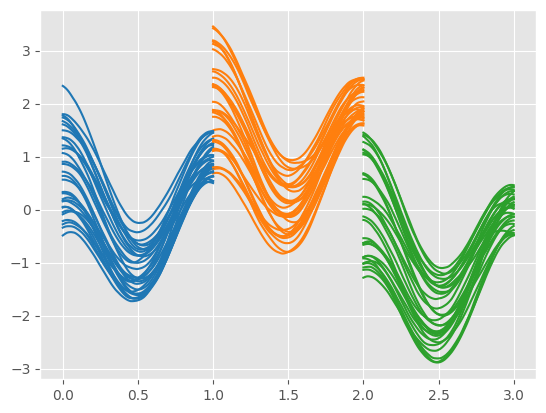

In [4]:
with mpl.style.context("ggplot"):
    cmap = mpl.colormaps["tab10"].colors
    fig, ax = plt.subplots()
    for demo in range(n_demos):
        ax.plot(T1, Y1[demo, :, 0], c=cmap[0])
        ax.plot(T2, Y2[demo, :, 0], c=cmap[1])
        ax.plot(T3, Y3[demo, :, 0], c=cmap[2])
    plt.show()

In [5]:
z = np.linspace(start=0, stop=1, num=n_steps)
z.shape

(103,)

## Learn the ProMPs

In [6]:
n_dims = 1
n_weights_per_dim = 10

In [7]:
promp1 = ProMP(n_dims=n_dims, n_weights_per_dim=n_weights_per_dim)
promp1.imitate([z] * n_demos, Y1)
Y_mean1 = promp1.mean_trajectory(z)
Y_conf1 = 1.96 * np.sqrt(promp1.var_trajectory(z))

promp2 = ProMP(n_dims=n_dims, n_weights_per_dim=n_weights_per_dim)
promp2.imitate([z] * n_demos, Y2)
Y_mean2 = promp2.mean_trajectory(z)
Y_conf2 = 1.96 * np.sqrt(promp2.var_trajectory(z))

promp3 = ProMP(n_dims=n_dims, n_weights_per_dim=n_weights_per_dim)
promp3.imitate([z] * n_demos, Y3)
Y_mean3 = promp3.mean_trajectory(z)
Y_conf3 = 1.96 * np.sqrt(promp3.var_trajectory(z))

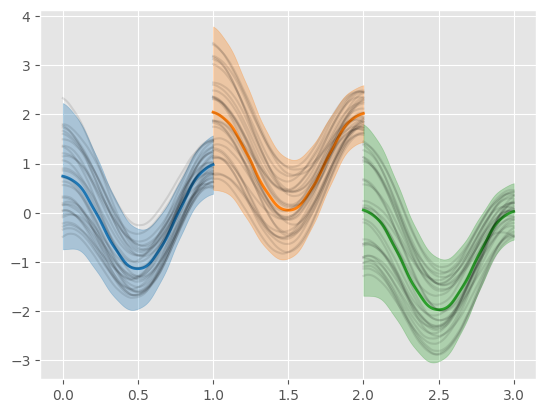

In [8]:
with mpl.style.context("ggplot"):
    cmap = mpl.colormaps["tab10"].colors
    fig, ax = plt.subplots()

    ax.fill_between(T1, (Y_mean1 - Y_conf1).ravel(), (Y_mean1 + Y_conf1).ravel(), color=cmap[0], alpha=0.3)
    ax.plot(T1, Y_mean1, c=cmap[0], lw=2)
    ax.plot(T1, Y1[:, :, 0].T, c="k", alpha=0.1)

    ax.fill_between(T2, (Y_mean2 - Y_conf2).ravel(), (Y_mean2 + Y_conf3).ravel(), color=cmap[1], alpha=0.3)
    ax.plot(T2, Y_mean2, c=cmap[1], lw=2)
    ax.plot(T2, Y2[:, :, 0].T, c="k", alpha=0.1)

    ax.fill_between(T3, (Y_mean3 - Y_conf3).ravel(), (Y_mean3 + Y_conf3).ravel(), color=cmap[2], alpha=0.3)
    ax.plot(T3, Y_mean3, c=cmap[2], lw=2)
    ax.plot(T3, Y3[:, :, 0].T, c="k", alpha=0.1)
    plt.show()

## Via-points

In [9]:
# def via_points(promp, ts, y_cond, y_conditional_cov=None):
#     if y_conditional_cov is None:
#         y_conditional_cov = np.zeros(y_cond.shape)

#     for idx, t_i in enumerate(ts):
#         promp = promp.condition_position(
#             y_mean=y_cond[idx],
#             y_cov=y_conditional_cov[[idx]],
#             t=t_i,
#             t_max=1.0
#         )
#     return promp

In [10]:
y_A = np.mean([Y_mean1[-1], Y_mean2[0]])
y_B = np.mean([Y_mean2[-1], Y_mean3[0]])
y_cond = np.array([y_A, y_B])
y_cond

array([1.51391313, 1.03896116])

In [11]:
x_cond = np.array([T1[-1], T2[-1]])
x_cond

array([1., 2.])

In [12]:
# y_conditional_cov = np.array([0.025])
y_conditional_cov = np.array([0.0])

In [13]:
# y_cov = np.eye(len(y_cond)) * y_conditional_cov
# y_cov, np.linalg.det(y_cov)

In [14]:
y_cov = np.tile(y_conditional_cov, 2)
y_cov

array([0., 0.])

In [15]:
cpromp1 = promp1.condition_position(np.array([y_A]), y_cov=y_conditional_cov, t=1.0, t_max=1.0)
Y_cmean1 = cpromp1.mean_trajectory(z)
Y_cconf1 = 1.96 * np.sqrt(cpromp1.var_trajectory(z))

In [16]:
zs = np.array([0.0, 1.0])
cpromp2 = via_points(promp2, ts=zs, y_cond=y_cond, y_conditional_cov=y_cov)
Y_cmean2 = cpromp2.mean_trajectory(z)
Y_cconf2 = 1.96 * np.sqrt(cpromp2.var_trajectory(z))

In [17]:
cpromp3 = promp3.condition_position(np.array([y_B]), y_cov=y_conditional_cov, t=0.0, t_max=1.0)
Y_cmean3 = cpromp3.mean_trajectory(z)
Y_cconf3 = 1.96 * np.sqrt(cpromp3.var_trajectory(z))

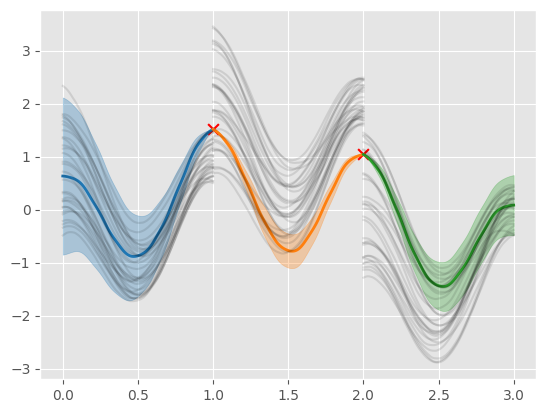

In [18]:
with mpl.style.context("ggplot"):
    cmap = mpl.colormaps["tab10"].colors
    fig, ax = plt.subplots()

    ax.fill_between(T1, (Y_cmean1 - Y_cconf1).ravel(), (Y_cmean1 + Y_cconf1).ravel(), color=cmap[0], alpha=0.3)
    ax.plot(T1, Y_cmean1, c=cmap[0], lw=2)
    ax.plot(T1, Y1[:, :, 0].T, c="k", alpha=0.1)

    ax.fill_between(T2, (Y_cmean2 - Y_cconf2).ravel(), (Y_cmean2 + Y_cconf2).ravel(), color=cmap[1], alpha=0.3)
    ax.plot(T2, Y_cmean2, c=cmap[1], lw=2)
    ax.plot(T2, Y2[:, :, 0].T, c="k", alpha=0.1)

    ax.fill_between(T3, (Y_cmean3 - Y_cconf3).ravel(), (Y_cmean3 + Y_cconf3).ravel(), color=cmap[2], alpha=0.3)
    ax.plot(T3, Y_cmean3, c=cmap[2], lw=2)
    ax.plot(T3, Y3[:, :, 0].T, c="k", alpha=0.1)

    ax.scatter(x_cond, y_cond, marker="x", c="r", s=60)
    plt.show()

## Multi via-points

In [19]:
n_demos = 50
n_steps = 101
T, Y = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1)
promp = ProMP(n_dims=1, n_weights_per_dim=50)
promp.imitate([T] * n_demos, Y)
Y_mean = promp.mean_trajectory(T)
Y_conf = 1.96 * np.sqrt(promp.var_trajectory(T))

y_cond = np.array([0.5, -0.5, 0.0, 0.5, 0.0])
cov = 0.25
y_conditional_cov = np.ones(len(y_cond)) * cov
ts = np.array([0.0, 0.2, 0.5, 0.7, 1.0])
cpromp = via_points(
    promp=promp,
    y_cond=y_cond,
    y_conditional_cov=y_conditional_cov,
    ts=ts,
)
Y_cmean = cpromp.mean_trajectory(T)
Y_cconf = 1.96 * np.sqrt(cpromp.var_trajectory(T))

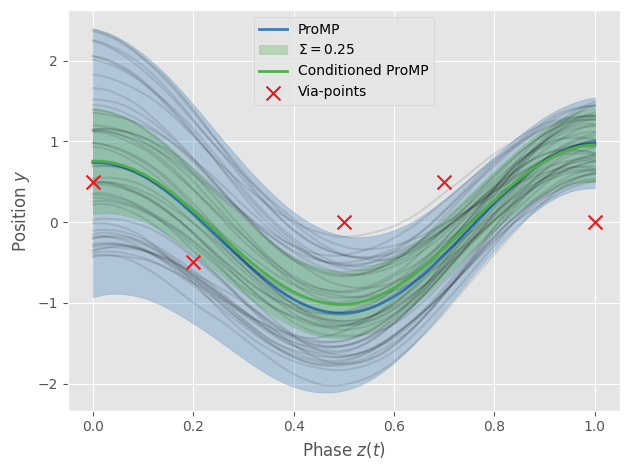

In [20]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps["Set1"].colors
    
    ax.fill_between(T, (Y_mean - Y_conf).ravel(), (Y_mean + Y_conf).ravel(), color=cmap[1], alpha=0.3)
    ax.plot(T, Y_mean, c=cmap[1], lw=2, label="ProMP")
    ax.plot(T, Y[:, :, 0].T, c="k", alpha=0.1)
    
    ax.fill_between(T, (Y_cmean - Y_cconf).ravel(), (Y_cmean + Y_cconf).ravel(), color=cmap[2], alpha=0.3, label=f"$\\Sigma={cov}$")
    ax.plot(T, Y_cmean, c=cmap[2], lw=2, label="Conditioned ProMP")
    ax.scatter(ts, y_cond, marker="x", s=100, color=cmap[0], label="Via-points", zorder=3)
    
    ax.legend(loc="best")
    ax.set_xlabel("Phase $z(t)$")
    ax.set_ylabel("Position $y$")
    plt.tight_layout()
    plt.show()

In [21]:
n_demos = 50
n_steps = 101
T, Y = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1)
promp = ProMP(n_dims=1, n_weights_per_dim=50)
promp.imitate([T] * n_demos, Y)
Y_mean = promp.mean_trajectory(T)
Y_conf = 1.96 * np.sqrt(promp.var_trajectory(T))

y_cond = np.array([0.5, -0.5, 0.0, 0.5, 0.0])
cov = 0.001
y_conditional_cov = np.ones(len(y_cond)) * cov
ts = np.array([0.0, 0.2, 0.5, 0.7, 1.0])
cpromp = via_points(
    promp=promp,
    y_cond=y_cond,
    y_conditional_cov=y_conditional_cov,
    ts=ts,
)
Y_cmean = cpromp.mean_trajectory(T)
Y_cconf = 1.96 * np.sqrt(cpromp.var_trajectory(T))

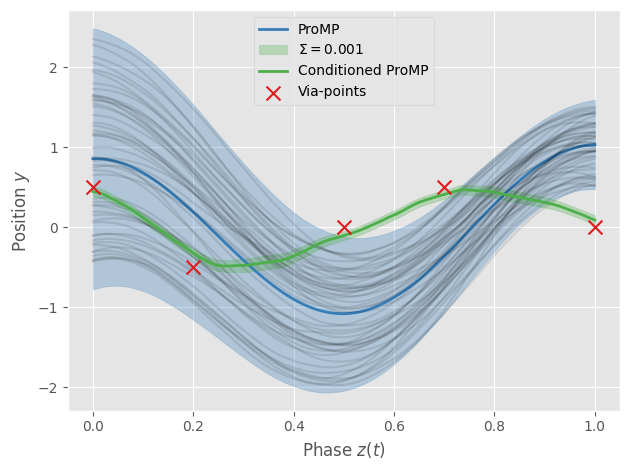

In [22]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps["Set1"].colors
    
    ax.fill_between(T, (Y_mean - Y_conf).ravel(), (Y_mean + Y_conf).ravel(), color=cmap[1], alpha=0.3)
    ax.plot(T, Y_mean, c=cmap[1], lw=2, label="ProMP")
    ax.plot(T, Y[:, :, 0].T, c="k", alpha=0.1)
    
    ax.fill_between(T, (Y_cmean - Y_cconf).ravel(), (Y_cmean + Y_cconf).ravel(), color=cmap[2], alpha=0.3, label=f"$\\Sigma={cov}$")
    ax.plot(T, Y_cmean, c=cmap[2], lw=2, label="Conditioned ProMP")
    ax.scatter(ts, y_cond, marker="x", s=100, color=cmap[0], label="Via-points", zorder=3)
    
    ax.legend(loc="best")
    ax.set_xlabel("Phase $z(t)$")
    ax.set_ylabel("Position $y$")
    plt.tight_layout()
    plt.show()

In [23]:
n_demos = 50
n_steps = 101
T, Y = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1)
promp = ProMP(n_dims=1, n_weights_per_dim=50)
promp.imitate([T] * n_demos, Y)
Y_mean = promp.mean_trajectory(T)
Y_conf = 1.96 * np.sqrt(promp.var_trajectory(T))

y_cond = np.array([0.5, -0.5, 0.0, 0.5, 0.0])
cov = 0.0
y_conditional_cov = np.ones(len(y_cond)) * cov
ts = np.array([0.0, 0.2, 0.5, 0.7, 1.0])
cpromp = via_points(
    promp=promp,
    y_cond=y_cond,
    y_conditional_cov=y_conditional_cov,
    ts=ts,
)
Y_cmean = cpromp.mean_trajectory(T)
Y_cconf = 1.96 * np.sqrt(cpromp.var_trajectory(T))

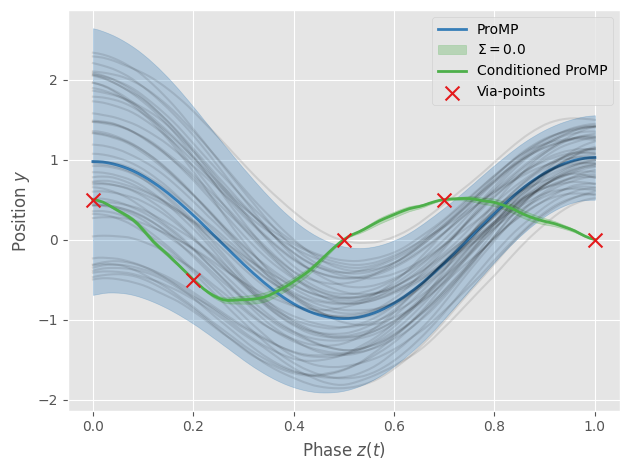

In [24]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps["Set1"].colors
    
    ax.fill_between(T, (Y_mean - Y_conf).ravel(), (Y_mean + Y_conf).ravel(), color=cmap[1], alpha=0.3)
    ax.plot(T, Y_mean, c=cmap[1], lw=2, label="ProMP")
    ax.plot(T, Y[:, :, 0].T, c="k", alpha=0.1)
    
    ax.fill_between(T, (Y_cmean - Y_cconf).ravel(), (Y_cmean + Y_cconf).ravel(), color=cmap[2], alpha=0.3, label=f"$\\Sigma={cov}$")
    ax.plot(T, Y_cmean, c=cmap[2], lw=2, label="Conditioned ProMP")
    ax.scatter(ts, y_cond, marker="x", s=100, color=cmap[0], label="Via-points", zorder=3)
    
    ax.legend(loc="best")
    ax.set_xlabel("Phase $z(t)$")
    ax.set_ylabel("Position $y$")
    plt.tight_layout()
    plt.show()

In [31]:
n_demos = 50
n_steps = 101
T, Y = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1)
promp = ProMP(n_dims=1, n_weights_per_dim=50)
promp.imitate([T] * n_demos, Y)
Y_mean = promp.mean_trajectory(T)
Y_conf = 1.96 * np.sqrt(promp.var_trajectory(T))

y_cond = np.array([0.5, 0.0, -1, 0.0])
cov = 0.2
y_conditional_cov = np.ones(len(y_cond)) * cov
ts = np.array([0.0, 0.2, 0.5, 0.7])
cpromp = via_points(
    promp=promp,
    y_cond=y_cond,
    y_conditional_cov=y_conditional_cov,
    ts=ts,
)
Y_cmean = cpromp.mean_trajectory(T)
Y_cconf = 1.96 * np.sqrt(cpromp.var_trajectory(T))

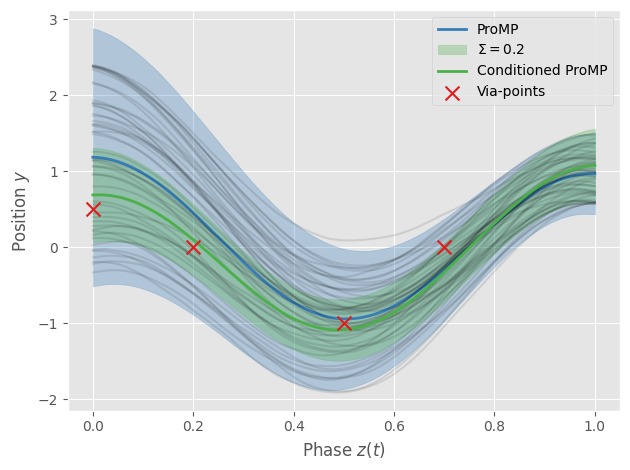

In [32]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps["Set1"].colors
    
    ax.fill_between(T, (Y_mean - Y_conf).ravel(), (Y_mean + Y_conf).ravel(), color=cmap[1], alpha=0.3)
    ax.plot(T, Y_mean, c=cmap[1], lw=2, label="ProMP")
    ax.plot(T, Y[:, :, 0].T, c="k", alpha=0.1)
    
    ax.fill_between(T, (Y_cmean - Y_cconf).ravel(), (Y_cmean + Y_cconf).ravel(), color=cmap[2], alpha=0.3, label=f"$\\Sigma={cov}$")
    ax.plot(T, Y_cmean, c=cmap[2], lw=2, label="Conditioned ProMP")
    ax.scatter(ts, y_cond, marker="x", s=100, color=cmap[0], label="Via-points", zorder=3)
    
    ax.legend(loc="best")
    ax.set_xlabel("Phase $z(t)$")
    ax.set_ylabel("Position $y$")
    plt.tight_layout()
    plt.show()

In [35]:
n_demos = 50
n_steps = 101
T, Y = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1)
promp = ProMP(n_dims=1, n_weights_per_dim=50)
promp.imitate([T] * n_demos, Y)
Y_mean = promp.mean_trajectory(T)
Y_conf = 1.96 * np.sqrt(promp.var_trajectory(T))

y_cond = np.array([0.5, 0.0, -1, 0.0])
cov = 0.01
y_conditional_cov = np.ones(len(y_cond)) * cov
ts = np.array([0.0, 0.2, 0.5, 0.7])
cpromp = via_points(
    promp=promp,
    y_cond=y_cond,
    y_conditional_cov=y_conditional_cov,
    ts=ts,
)
Y_cmean = cpromp.mean_trajectory(T)
Y_cconf = 1.96 * np.sqrt(cpromp.var_trajectory(T))

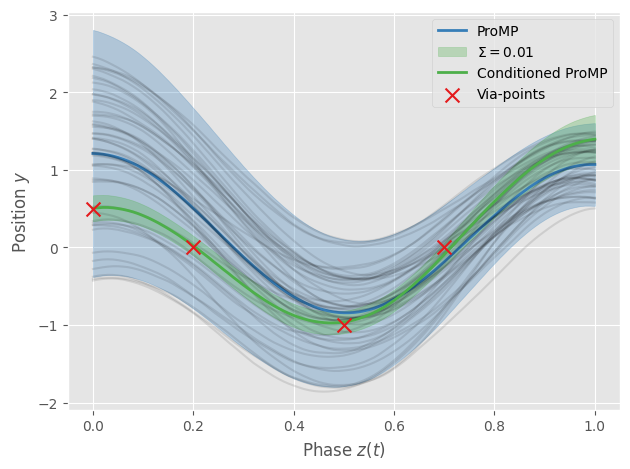

In [36]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps["Set1"].colors
    
    ax.fill_between(T, (Y_mean - Y_conf).ravel(), (Y_mean + Y_conf).ravel(), color=cmap[1], alpha=0.3)
    ax.plot(T, Y_mean, c=cmap[1], lw=2, label="ProMP")
    ax.plot(T, Y[:, :, 0].T, c="k", alpha=0.1)
    
    ax.fill_between(T, (Y_cmean - Y_cconf).ravel(), (Y_cmean + Y_cconf).ravel(), color=cmap[2], alpha=0.3, label=f"$\\Sigma={cov}$")
    ax.plot(T, Y_cmean, c=cmap[2], lw=2, label="Conditioned ProMP")
    ax.scatter(ts, y_cond, marker="x", s=100, color=cmap[0], label="Via-points", zorder=3)
    
    ax.legend(loc="best")
    ax.set_xlabel("Phase $z(t)$")
    ax.set_ylabel("Position $y$")
    plt.tight_layout()
    plt.show()